## Monthly QE NCR Metrics

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from datetime import datetime as dt
import numpy as np
from config import epicorConnectionString, unipointConnectionString
import re
%matplotlib inline
%config IPCompleter.greedy=True

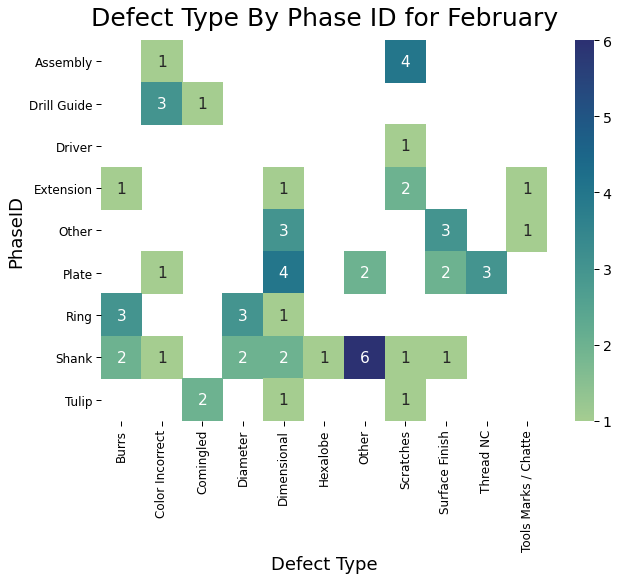

In [45]:
"""
CHANGE DATES AS NEEDED, format = "'yyyy-mm-dd'"
results are between and including the given dates
"""
from_date = "'2021-02-01'"
to_date = "'2021-03-01'"

# SQL Connection
con = create_engine(unipointConnectionString).connect()

# Format SQL Query with the provided date
NC_df_Query = None

with open('sql\\NC_Classification_Month.sql') as f:
    NC_df_Query = f.read().format(start=from_date, end=to_date)

# Initialize DataFrames
NC_df = pd.read_sql(text(NC_df_Query), con)
Dept_df = pd.read_csv('csv\JCDept.csv',names=['Origin_ref','Origin'])

# Merge Data Frames, translate dept codes into Names
Dept_df['Origin_ref'] = Dept_df['Origin_ref'].astype('object')
NC_df = NC_df.merge(Dept_df, how='left', on='Origin_ref')
NC_df['NCR_Date'] = NC_df['NCR_Date'].astype('datetime64')


# Grab the 3 columns that we care about and groupby in order to count the number of occurences
NC_month_gb_df = NC_df[['Reference','Class','Status']]

pd.set_option('display.max_rows', NC_month_gb_df.shape[0]+1)

# Becuase the phaseIDs in the form must be hand-typed, they don't always match up with the desired grouping. Assing them new values based on True for fitting 
#     regular expressions
for phaseID in ['Assembly','Clip Ring','Connector','Drill Guide','Driver','Extension','Load Ring','Other','Peek','Plate','Raw Material','Ring','Shank','Tooling','Tower','Tulip']:
    NC_month_gb_df['Reference'][NC_month_gb_df['Reference'].str.contains(r"({0})".format(phaseID), flags=re.IGNORECASE)] = phaseID


NC_month_gb_df = NC_month_gb_df.groupby(['Reference','Class'])['Status'].count().reset_index()
NC_month_gb_df = NC_month_gb_df.pivot('Reference', 'Class','Status')

# Setup Plot
sns.set_context('paper', font_scale=1.6)
f, ax = plt.subplots(figsize=(10,7))

# Plot Heatmap
# https://seaborn.pydata.org/tutorial/color_palettes.html
cmap = sns.color_palette('crest', as_cmap=True)
sns.heatmap(NC_month_gb_df, annot=True, cmap=cmap, ax=ax, cbar_kws={'orientation': 'vertical'})

# Decorators
plt.xlabel("Defect Type", fontsize=18)
plt.ylabel("PhaseID", fontsize=18)
plt.title('Defect Type By Phase ID for ' + dt.strptime(from_date.strip("'"),'%Y-%m-%d').strftime('%B'), fontsize=25, pad=15.0)
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=90, fontsize=12)

# Close Connections
con.close()

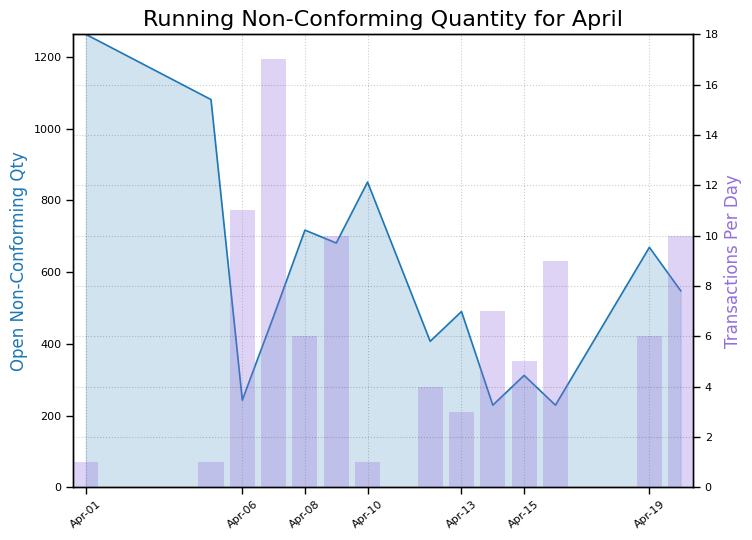

In [47]:

"""
CHANGE AS NEEDED, date format in 'yyyy-mm-dd'
"""
from_date = "'2021-04-01'"
to_date = "'2021-04-20'"


# Read the queries from our working sql files
prevDFQuery = None
monthDFQuery = None

with open("sql\LeadingMonth.sql") as prevF, open("sql\MonthlyActivity.sql") as monthF:
    prevDFQuery = prevF.read().format(start=from_date)
    monthDFQuery = monthF.read().format(start=from_date, end=to_date)
    
# SQL Connection
con = create_engine(epicorConnectionString).connect()

# Get the ongoing results leading up to the from_date into a single row
prevDF = pd.read_sql(text(prevDFQuery), con)

prevDF = prevDF.drop(['CreateDate', 'JobNum'], axis=1)
prevDF = pd.DataFrame({'JobNum': 'LastMonth', 'DiscrepQty': prevDF['DiscrepQty'].sum(), 
                       'CreateDate': np.datetime64(from_date.strip("'"))}, index=[0])


# Get results from_date -> to_date
monthDF = pd.read_sql(text(monthDFQuery), con)
monthDF['CreateDate'] = pd.to_datetime(monthDF['CreateDate'])


# Concatenate the two frames and groupby on the date, creat columns for the count(*) and ongoing qty
totalDF = pd.concat([prevDF,monthDF], ignore_index=True)

totalDF['Transactions'] = np.zeros(len(totalDF.index))
totalDF = totalDF.groupby(by='CreateDate', as_index=False).agg({'DiscrepQty':'sum',
                                      'JobNum': 'max',
                                      'Transactions': 'count'})
totalDF['RunningSum'] = totalDF['DiscrepQty'].cumsum()

# Setup Figure
plt.figure(figsize=(8,6), dpi=100)
ax = plt.gca()
ax2 = ax.twinx()

# Plot time series and bar plot
ax.plot('CreateDate','RunningSum', data=totalDF, color='tab:blue')
ax2.bar('CreateDate', 'Transactions', data=totalDF, color='mediumpurple', alpha=.3)

# Format labels to legible dates and whole integers
xtick_labels = totalDF['CreateDate'].apply(lambda x: x.strftime("%b-%d")).tolist()
plt.xticks(ticks=totalDF['CreateDate'].tolist()[::2],labels=xtick_labels[::2], alpha=.7)
ytick_labels = ax2.get_yticks().tolist()
ax2.set_yticks((np.arange(min(ytick_labels), max(ytick_labels) +1))[::2])

# Decorators
ax.tick_params(axis='x', labelrotation=40, labelsize=8)
ax.tick_params(axis='y', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)

ax.margins(x=0,y=0, tight=True)
ax.grid(axis='x', alpha=.2, color='k', ls=':', lw=.8)
plt.grid(axis='both', alpha=.2, color='k', ls=':',lw=.8)
ax.set_ylabel('Open Non-Conforming Qty', color='tab:blue', fontsize=12)
ax2.set_ylabel('Transactions Per Day', color='mediumpurple', fontsize=12)

# Fill underneath the time series
ax.fill_between(x=totalDF.CreateDate.tolist(),y1=totalDF.RunningSum.tolist(),y2=0,alpha=0.2,color='tab:blue')

plt.title("Running Non-Conforming Quantity for " + 
          dt.strptime(from_date.strip("'"),'%Y-%m-%d').strftime('%B'), fontsize=16)

# Close connection
con.close()
